In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
data = pd.read_csv('data.txt', delim_whitespace=True)

In [3]:
def separate_by_name(data):
    #subsetting the dataframe by micrograph name
    i = 0
    micrographs = []
    df1 = None
    name = data.loc[0]["MicrographName"]
    oldIndex = 0
    newIndex = 0
    while (i < data.shape[0]):
        if (data.loc[i]["MicrographName"] != name):
            micrographs.append(data.iloc[oldIndex:i,:])
            oldIndex = i
            name = data.loc[i]["MicrographName"]
        i = i+1
    return micrographs

In [4]:
newlist = separate_by_name(data)

In [5]:
newlist[0].iloc[0,0]

3854.031754

In [6]:
def scatter(micrograph):
   #select micrograph 1 as example, plotting it using matplotlib
    for (x,y) in list(zip(micrograph.X0, micrograph.Y0)):
        plt.scatter(x,y) 

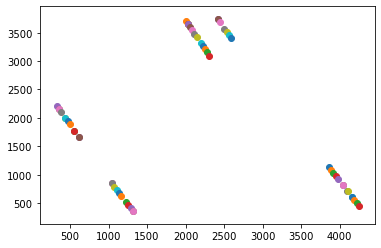

In [7]:
scatter(newlist[0])

In [8]:
def psi_extrapolate(x,y, psi, inter_dist, direction):
    dx = math.cos(psi)*inter_dist
    dy = math.sin(psi)*inter_dist
    if (direction):
        #positive direction
        new_point = (x+dx, y+dy)
    else:
        new_point = (x-dx, y-dy)
    return new_point

def L2_dist(x,y, x1, y1):
    return math.sqrt(math.pow((x-x1),2)+math.pow((y-y1),2))

In [9]:
def post_shift_data(dataframe, binning_factor):
    df = dataframe.copy(deep = True)
    for i in range(df.shape[0]):
        df.iloc[i,0] = df.iloc[i,0]+binning_factor*df.iloc[i,4]
        df.iloc[i,1] = df.iloc[i,1]+binning_factor*df.iloc[i,5]
    return df

In [10]:
post_shift_df = post_shift_data(newlist[0],1.7448/1.37)
post_shift_df.iloc[0]

X0                                                          3853.16
Y0                                                          1139.73
helicalID                                                         1
MicrographName    MotionCorr/job008/Movies/hole4/k40r_cflat_0001...
ShiftX                                                     -0.68591
ShiftY                                                     0.140838
AngleRot                                                   -24.3609
AngleTilt                                                   92.3467
AnglePsi                                                    60.0434
Name: 0, dtype: object

In [11]:
def plot_psi(dataframe):
    i = 1
    for Psi in list(dataframe.AnglePsi):
        plt.scatter(i, Psi)
        i = i + 1
        
def plot_psi_np(numpy_arr):
    for i in range(numpy_arr.shape[0]):
        plt.scatter(i+1, numpy_arr[i][8])
        
def plot_rot(dataframe):
    i = 1
    for rot in list(dataframe.AngleRot):
        plt.scatter(i, rot)
        i = i + 1

def plot_tilt(dataframe):
    i = 1
    for tilt in list(dataframe.AngleTilt):
        plt.scatter(i, tilt)
        i = i + 1

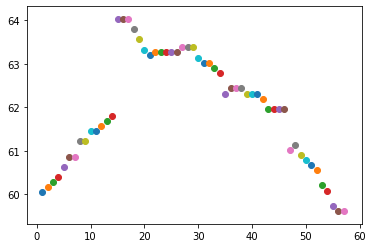

In [12]:
plot_psi(post_shift_df)

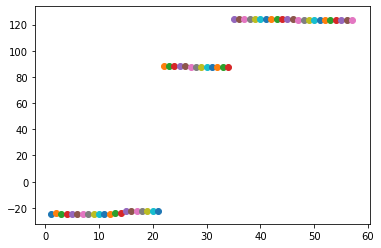

In [13]:
plot_rot(post_shift_df)

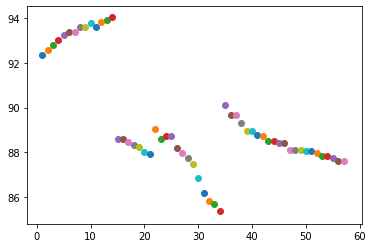

In [14]:
plot_tilt(post_shift_df)

In [15]:
data_matrix = post_shift_df.to_numpy()

In [16]:
def point_search(helix, point, xmin, xmax, ymin, ymax, dist, direction):
    helix = np.copy(helix)
    final_points = []
    rand_point = point
    while (True):
        theoretical_next = psi_extrapolate(rand_point[0], rand_point[1], -1 * math.radians(rand_point[8]), dist ,
                                           direction)
        # check the nearest points in data_matrix to these two points, if none are there, plot a temporary point and include it in the final points
        if (theoretical_next[0] > xmax or theoretical_next[1] > ymax or theoretical_next[0] < xmin or
                theoretical_next[1] < ymin):
            break
        i = 0
        point_found = False
        for point1, point2 in zip(helix[:, 0], helix[:, 1]):
            if L2_dist(theoretical_next[0], theoretical_next[1], point1, point2) < 15:
                final_points.append((point1, point2))
                rand_point = helix[i]
                helix = np.delete(helix, i, 0)
                point_found = True
                break
            i = i + 1
        if (point_found == False):
            final_points.append(theoretical_next)
            rand_point[0] = theoretical_next[0]
            rand_point[1] = theoretical_next[1]
    return final_points

In [17]:
def get_helices(data_matrix):
    return np.split(data_matrix, np.where(np.diff(data_matrix[:,2]))[0]+1)

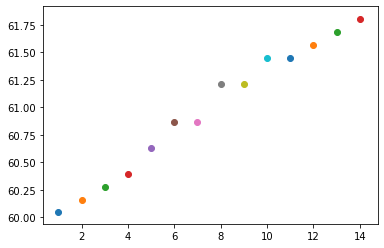

In [18]:
helices = get_helices(data_matrix)
plot_psi_np(helices[0])

In [19]:
def mad(arr):
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))*1.4826

def std_mad(arr):
    return (arr - np.median(arr))/mad(arr)

def adjust_psi(helix, standard_dev_coefficient):
    arr = std_mad(helix[:,8])
    new_arr = helix[:,8][np.abs(arr)<standard_dev_coefficient]
    mean_psi = np.mean(new_arr)

    for i in range(helix.shape[0]):
        if np.abs(arr[i]) > standard_dev_coefficient:
            helix[i,8] = mean_psi
    return helix

In [20]:
helices[0]

array([[3853.1581950452555, 1139.7260789871532, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.68591, 0.14083800000000002, -24.360870000000002, 92.346744,
        60.043434],
       [3884.665992891971, 1086.577413140438, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.85916, 0.31408800000000003, -24.273039999999998, 92.57078,
        60.160669999999996],
       [3915.394436891971, 1034.4287472937226, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.85916, 0.487338, -24.36099, 92.79480799999999, 60.277804],
       [3946.1228818919712, 981.2297761696351, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.85916, 0.621088, -24.44894, 93.018878, 60.394937],
       [3978.0719730452556, 926.4694751404379, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.68591, 0.31408800000000003, -24.53689, 93.242994,
        60.62925799999999],
    

In [21]:
for helix in helices:
    adjust_psi(helix, 1)


[4100.597386227737 713.383212169635 1
 'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc'
 -0.20565999999999998 0.621088 -24.62489 93.616647 61.215138]


In [22]:
helices[0]

array([[3853.1581950452555, 1139.7260789871532, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.68591, 0.14083800000000002, -24.360870000000002, 92.346744,
        61.1331897],
       [3884.665992891971, 1086.577413140438, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.85916, 0.31408800000000003, -24.273039999999998, 92.57078,
        61.1331897],
       [3915.394436891971, 1034.4287472937226, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.85916, 0.487338, -24.36099, 92.79480799999999, 61.1331897],
       [3946.1228818919712, 981.2297761696351, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.85916, 0.621088, -24.44894, 93.018878, 60.394937],
       [3978.0719730452556, 926.4694751404379, 1,
        'MotionCorr/job008/Movies/hole4/k40r_cflat_00012_4-1.mrc',
        -0.68591, 0.31408800000000003, -24.53689, 93.242994,
        60.62925799999999],
       [40

In [23]:
import threading
import os
import concurrent.futures

#fitting algorithm

import random

fitted_points = []

#loop through each helix

for helix in helices:
    fitted_points_in_helix = []
    rand_point = helix[random.randrange(0, helix.shape[0])]
    
    max_x = np.amax(helix,axis=0)[0]
    max_y = np.amax(helix,axis=0)[1]
    
    min_x = np.amin(helix,axis=0)[0]
    min_y = np.amin(helix,axis=0)[1]
    
    #two thread process to compute positive extrapolation and negative extrapolation at the same time
    with concurrent.futures.ThreadPoolExecutor() as executor:
        parameters = [(helix, rand_point ,min_x, max_x, min_y, max_y, 82.5, True), (helix, rand_point ,min_x, max_x, min_y, max_y, 82.5, False)]
        futures = [executor.submit(point_search, param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7]) for param in parameters]
        return_values = [future.result() for future in futures]
        fitted_points_in_helix = [item for sublist in return_values for item in sublist]
    for x in fitted_points_in_helix:
        fitted_points.append(x)

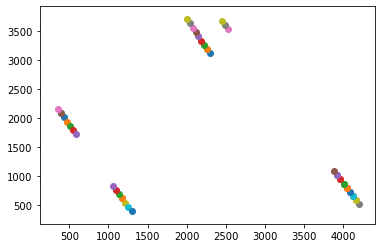

In [24]:
#select micrograph 1 as example, plotting it using matplotlib
for (x,y) in fitted_points:
    plt.scatter(x,y)
    

(array([13, 20, 33, 45], dtype=int64),)

hello world!
foo
